# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
!pip3 install -q Pillow==7.1.0

     |████████████████████████████████| 2.1MB 18.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2021-04-16 18:25:47--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.62.128, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M   188MB/s    in 2.9s    

2021-04-16 18:25:50 (188 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2021-04-16 18:25:54--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.8.16, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.

In [46]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

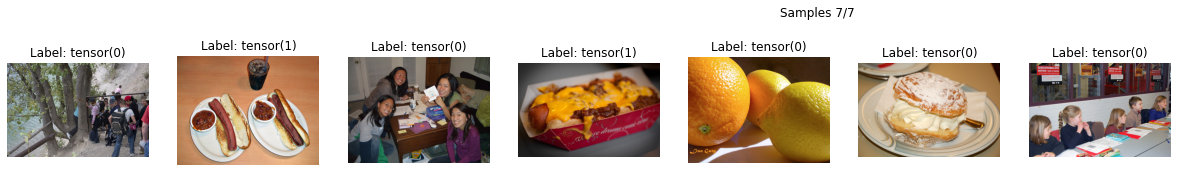

In [47]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        # TODO: Your code here!
        self.folder = folder
        self.count_of_files = len(next(os.walk(self.folder))[2])
        
    def __len__(self):
        return self.count_of_files
    
    def __getitem__(self, index):        
        img_id = os.listdir(self.folder)[index]
        img_name = os.path.join(self.folder, img_id)
        img = Image.open(img_name) 
        if self.transform is not None:
            img = self.transform(img)

        img = torch.from_numpy(np.asarray(img) / 255) 
        # print(img.shape)

        names = ["frankfurter", "chili-dog", "hotdog"]
        y = None
        if img_id.find(names[0]) != -1 or \
           img_id.find(names[1]) != -1 or \
           img_id.find(names[2]) != -1:
           y = 1
        else:
           y = 0

        return img, torch.from_numpy(np.asarray(y)), img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

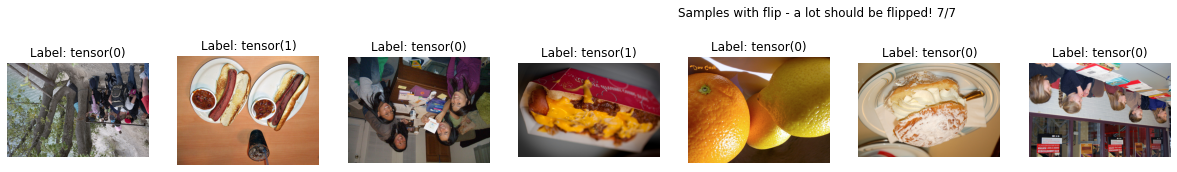

In [48]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [49]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [50]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [60]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        if scheduler is not None:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct, all_ = 0, 0
    for x, y, z in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        scores = model(x_gpu)
        _, preds = scores.max(1)
        correct += (preds == y_gpu).sum()
        all_ += preds.size(0)
    
    model.train()
    
    return correct/all_


# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

563 is letter_opener
1479 is letter_opener
3549 is letter_opener
2908 is letter_opener
3573 is letter_opener
3922 is letter_opener
1933 is letter_opener
1585 is letter_opener
986 is letter_opener
2036 is letter_opener


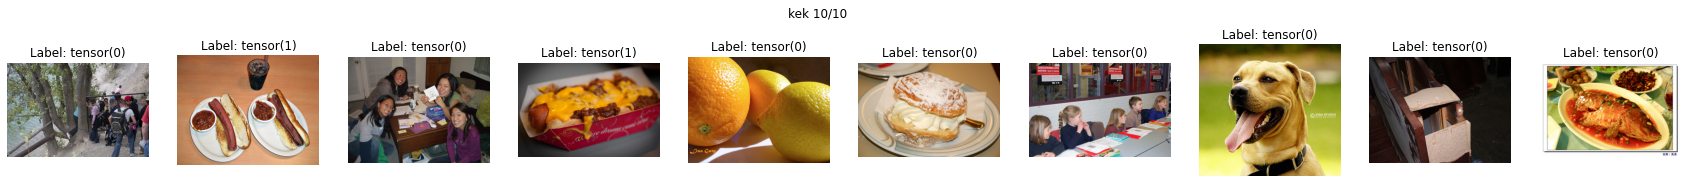

In [52]:
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)

# print(load_imagenet_classes())

def show_in_which_class(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    a = dict()

    for i, (x, y, z) in enumerate(loader):
        scores = model(x)
        _, preds = scores.max(1)
        a[i] = preds
    
    model.train()
    
    return a

indeces = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)

subset = torch.utils.data.Subset(train_dataset, indeces)
testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)
x = show_in_which_class(model, testloader_subset)

dict_ = load_imagenet_classes()
for i in x:
    print(f"{indeces[i]} is {dict_[x[0].item()]}")

visualize_samples(orig_dataset, indeces, title="kek")


# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [10]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2) # 1 - hotdog, 0 - not hotdog
model = model.to(device)

parameters = model.fc.parameters()   

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.387923, Train accuracy: 0.819169, Val accuracy: 0.673913
Average loss: 0.214953, Train accuracy: 0.919088, Val accuracy: 0.925000


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [ ]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2) # 1 - hotdog, 0 - not hotdog
model = model.to(device)

parameters = model.parameters()   

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.345165, Train accuracy: 0.830844, Val accuracy: 0.716304
Average loss: 0.149548, Train accuracy: 0.943524, Val accuracy: 0.950000
Average loss: 0.100891, Train accuracy: 0.966332, Val accuracy: 0.957609
Average loss: 0.076845, Train accuracy: 0.973663, Val accuracy: 0.953261
Average loss: 0.050751, Train accuracy: 0.987782, Val accuracy: 0.954348


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [53]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)

loss = nn.CrossEntropyLoss()
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2) # 1 - hotdog, 0 - not hotdog
model = model.to(device)

# for a, b in model.named_parameters():
#     print(a == "fc.weight")
names = {"fc.weight", "fc.bias"}

# print([a for a, b in model.named_parameters() if a in names])
optimizer = optim.SGD([
                {'params': model.fc.parameters()},
                {'params': [b for a, b in model.named_parameters() if a not in names], 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.296639, Train accuracy: 0.891393, Val accuracy: 0.698913
Average loss: 0.102243, Train accuracy: 0.962259, Val accuracy: 0.945652
Average loss: 0.069869, Train accuracy: 0.975020, Val accuracy: 0.941304
Average loss: 0.025047, Train accuracy: 0.991583, Val accuracy: 0.956522
Average loss: 0.007734, Train accuracy: 0.998914, Val accuracy: 0.953261


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [54]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, sampler=SubsetSampler(indices))
    predictions = np.zeros((len(indices)))
    ground_truth = np.zeros((len(indices)))
    for i, (x, y, z) in enumerate(loader):
        x_gpu = x.to(device)
        pred = model(x_gpu)
        # print(y.numpy()[0])
        predictions[i] = np.argmax(pred.data.tolist()[0])
        ground_truth[i] = y.detach().numpy()[0]    
    return predictions, ground_truth

print(train_dataset[0][0].shape)
predictions, gt = evaluate_model(model, train_dataset, val_indices)
# print(val_indices)

torch.Size([3, 224, 224])


И теперь можно визуализировать false positives и false negatives.

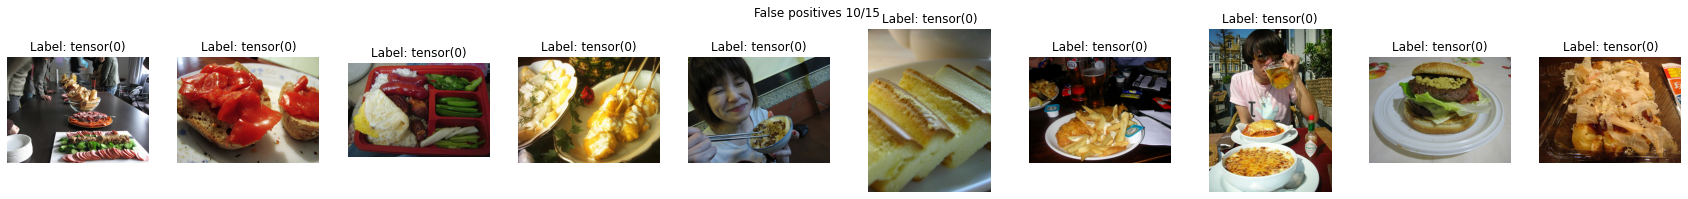

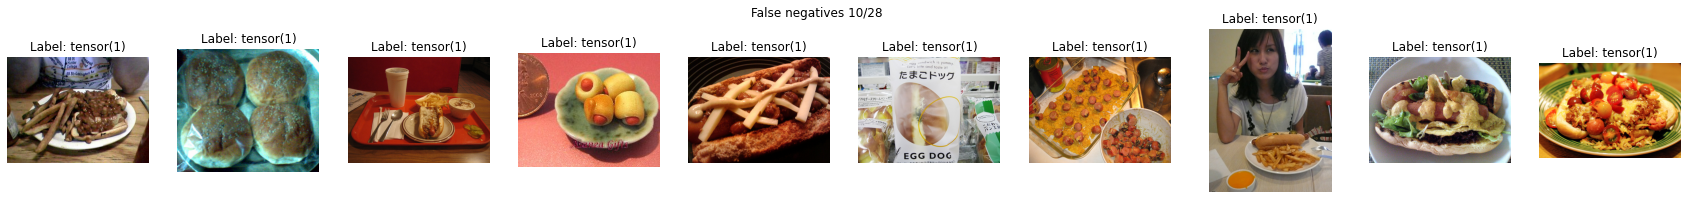

In [55]:
false_positive_indices = list()

false_negatives_indices = list()

for i in range(len(predictions)):
	if predictions[i] != gt[i]:
		if predictions[i] == 0:
			false_negatives_indices.append(val_indices[i])
		else:
			false_positive_indices.append(val_indices[i])
   
# print(predictions, gt, false_positive_indices, false_negatives_indices, sep='\n')
visualize_samples(orig_dataset, false_positive_indices, "False positives")
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [56]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(len(prediction)):
        if prediction[i] == ground_truth[i]:
            if prediction[i]:
                TP += 1
            else:
                TN += 1

        else:
            if prediction[i]:
                FP += 1
            else:
                FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = (1 + 1) * precision * recall / (1 * precision + recall)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.927, P: 0.948, R: 0.908


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [64]:
model = models.resnet18(pretrained=True)

loss = nn.CrossEntropyLoss()
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, 2) # 1 - hotdog, 0 - not hotdog
model = model.to(device)

names = {"fc.weight", "fc.bias"}

optimizer = optim.SGD([
                {'params': model.fc.parameters()},
                {'params': [b for a, b in model.named_parameters() if a not in names], 'lr': 1e-3}
            ], lr=1e-2, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader,
                                                       loss, optimizer, 7, exp_lr_scheduler)




Average loss: 0.253459, Train accuracy: 0.898452, Val accuracy: 0.684783
Average loss: 0.128480, Train accuracy: 0.954113, Val accuracy: 0.952174
Average loss: 0.044189, Train accuracy: 0.983437, Val accuracy: 0.955435
Average loss: 0.020661, Train accuracy: 0.992669, Val accuracy: 0.953261
Average loss: 0.011848, Train accuracy: 0.998371, Val accuracy: 0.953261
Average loss: 0.008485, Train accuracy: 0.998642, Val accuracy: 0.957609
Average loss: 0.006262, Train accuracy: 0.999457, Val accuracy: 0.958696


In [65]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))



F1: 0.936, P: 0.962, R: 0.911


## Визуализируйте ошибки лучшей модели

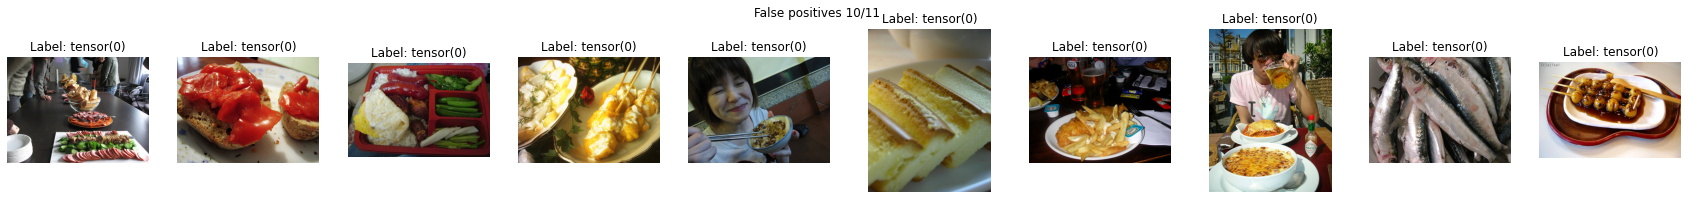

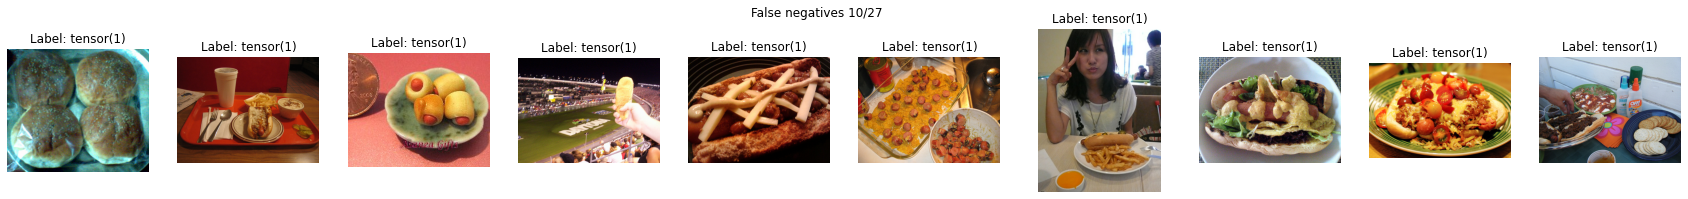

In [66]:

false_positive_indices = list()
false_negatives_indices = list()

for i in range(len(predictions)):
	if predictions[i] != gt[i]:
		if predictions[i] == 0:
			false_negatives_indices.append(val_indices[i])
		else:
			false_positive_indices.append(val_indices[i])
   
visualize_samples(orig_dataset, false_positive_indices, "False positives")
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")